In [1]:
# System
import os
import sys
import logging
import multiprocessing as mp
from functools import partial
from collections import Counter

# Externals
import yaml
import pickle
import numpy as np
import pandas as pd
import trackml.dataset
from time import time
from torch_geometric.data import Data
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import MessagePassing
from torch.nn import Sequential as Seq, Linear, ReLU, Sigmoid
from torch import optim
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch.optim.lr_scheduler import StepLR

# from torch_geometric.nn import GravNetConv

In [2]:
class GraphDataset(Dataset):
    def __init__(self, transform=None, pre_transform=None, graph_files=[]):
        super(GraphDataset, self).__init__(None, transform, pre_transform)
        self.graph_files = graph_files

    @property
    def raw_file_names(self):
        return self.graph_files

    @property
    def processed_file_names(self):
        return []

    def len(self):
        return len(self.graph_files)

    def get(self, idx):
        with np.load(self.graph_files[idx]) as f:
            # for k in f.iterkeys(): print(k)
            x = torch.from_numpy(f["x"])
            edge_attr = torch.from_numpy(f["edge_attr"])
            edge_index = torch.from_numpy(f["edge_index"])
            y = torch.from_numpy(f["y"])
            particle_id = torch.from_numpy(f["particle_id"])

            # make graph undirected
            row_0, col_0 = edge_index
            row = torch.cat([row_0, col_0], dim=0)
            col = torch.cat([col_0, row_0], dim=0)
            edge_index = torch.stack([row, col], dim=0)
            negate = torch.tensor([[-1], [-1], [-1], [1]])
            edge_attr = torch.cat([edge_attr, negate * edge_attr], dim=1)
            y = torch.cat([y, y])

            data = Data(
                x=x,
                edge_index=edge_index,
                edge_attr=torch.transpose(edge_attr, 0, 1),
                y=y,
                particle_id=particle_id,
            )
            data.num_nodes = len(x)

        return (data, self.graph_files[idx])

In [5]:
input_dir = "../graphs/train1_ptmin1"
graph_files = np.array(os.listdir(input_dir))
graph_paths = np.array(
    [os.path.join(input_dir, graph_file) for graph_file in graph_files]
)
# print(np.unique([f.split('00000')[-1].split('_')[0] for f in graph_paths ]))

n_graphs = len(graph_files)
IDs = np.arange(n_graphs)
np.random.shuffle(IDs)
partition = {
    "train": graph_paths[IDs[:1500]],
    "test": graph_paths[IDs[1500:1700]],
    "val": graph_paths[IDs[1700:1750]],
}
params = {"batch_size": 1, "shuffle": True, "num_workers": 1}
train_set = GraphDataset(graph_files=partition["train"])
train_loader = DataLoader(train_set, **params)
test_set = GraphDataset(graph_files=partition["test"])
test_loader = DataLoader(test_set, **params)
val_set = GraphDataset(graph_files=partition["val"])
val_loader = DataLoader(val_set, **params)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

for batch_idx, (data, f) in enumerate(train_loader):
    data = data.to(device)
    print(f, "\n", data)
    if batch_idx > 3:
        break

('../graphs/train1_ptmin1/event000001257_s26.npz',) 
 Batch(x=[266, 3], edge_index=[2, 7080], edge_attr=[7080, 4], y=[7080], particle_id=[266], num_nodes=266, batch=[266], ptr=[2])
('../graphs/train1_ptmin1/event000001132_s30.npz',) 
 Batch(x=[430, 3], edge_index=[2, 3600], edge_attr=[3600, 4], y=[3600], particle_id=[430], num_nodes=430, batch=[430], ptr=[2])
('../graphs/train1_ptmin1/event000001102_s63.npz',) 
 Batch(x=[118, 3], edge_index=[2, 502], edge_attr=[502, 4], y=[502], particle_id=[118], num_nodes=118, batch=[118], ptr=[2])
('../graphs/train1_ptmin1/event000001059_s59.npz',) 
 Batch(x=[281, 3], edge_index=[2, 12990], edge_attr=[12990, 4], y=[12990], particle_id=[281], num_nodes=281, batch=[281], ptr=[2])
('../graphs/train1_ptmin1/event000001115_s8.npz',) 
 Batch(x=[95, 3], edge_index=[2, 404], edge_attr=[404, 4], y=[404], particle_id=[95], num_nodes=95, batch=[95], ptr=[2])


In [6]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(MLP, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, C):
        return self.layers(C)


class RelationalModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(RelationalModel, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, m):
        return self.layers(m)


class ObjectModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(ObjectModel, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, C):
        return self.layers(C)


class InteractionNetwork(MessagePassing):
    def __init__(
        self,
        node_indim,
        edge_indim,
        node_outdim=3,
        edge_outdim=4,
        hidden_size=40,
        aggr="add",
    ):
        super(InteractionNetwork, self).__init__(aggr=aggr, flow="source_to_target")
        self.R1 = RelationalModel(2 * node_indim + edge_indim, edge_outdim, hidden_size)
        self.O = ObjectModel(node_indim + edge_outdim, node_outdim, hidden_size)
        self.E_tilde: Tensor = Tensor()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor) -> Tensor:
        # propagate_type: (x: Tensor, edge_attr: Tensor)
        x_tilde = self.propagate(edge_index, x=x, edge_attr=edge_attr, size=None)
        return x_tilde, self.E_tilde

    def message(self, x_i, x_j, edge_attr):
        # x_i --> incoming, x_j --> outgoing
        m1 = torch.cat([x_i, x_j, edge_attr], dim=1)
        self.E_tilde = self.R1(m1)
        return self.E_tilde

    def update(self, aggr_out, x):
        c = torch.cat([x, aggr_out], dim=1)
        return self.O(c)


# class GNN(nn.Module):
#    def __init__(self):
#        super(GNN, self).__init__()
#        self.in1 = InteractionNetwork(3, 4, node_outdim=3,
#                                      edge_outdim=4, hidden_size=80)
#        self.in2 = InteractionNetwork(3, 4, node_outdim=3,
#                                      edge_outdim=4, hidden_size=80,
#                                      aggr='max')
#        #self.in3 = InteractionNetwork(3, 4, node_outdim=3,
#        #                              edge_outdim=4, hidden_size=100,
#        #                              aggr='max')
#        self.in_c = InteractionNetwork(3, 5, node_outdim=2,
#                                       edge_outdim=4, hidden_size=80)
#        self.W = MLP(12, 1, 80)
#        self.B = MLP(2, 1, 40)
#
#    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor) -> Tensor:
#        x1, edge_attr_1 = self.in1(x, edge_index, edge_attr)
#        x2, edge_attr_2 = self.in2(x1, edge_index, edge_attr_1)
#        #x3, edge_attr_3 = self.in3(x2, edge_index, edge_attr_2)
#        all_edge_attr = torch.cat([edge_attr, edge_attr_1,
#                                   edge_attr_2], dim=1) #edge_attr_3], dim=1)
#
#        edge_weights = torch.sigmoid(self.W(all_edge_attr))
#        edge_attr_weights = torch.cat([edge_weights, edge_attr], dim=1)
#        xc, edge_attr_c = self.in_c(x, edge_index, edge_attr_weights)
#        beta = torch.sigmoid(self.B(xc))
#        return edge_weights, xc, beta


class GNN(nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.in1 = InteractionNetwork(
            3, 4, node_outdim=3, edge_outdim=4, hidden_size=50
        )
        self.in2 = InteractionNetwork(
            3, 4, node_outdim=3, edge_outdim=4, hidden_size=50
        )
        self.in3 = InteractionNetwork(
            3, 13, node_outdim=3, edge_outdim=8, hidden_size=50
        )
        self.in4 = InteractionNetwork(
            3, 8, node_outdim=3, edge_outdim=8, hidden_size=50
        )
        self.in5 = InteractionNetwork(
            3, 8, node_outdim=3, edge_outdim=8, hidden_size=50
        )
        self.W = MLP(12, 1, 80)
        self.B = MLP(18, 1, 80)
        self.X = MLP(18, 2, 80)

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor) -> Tensor:
        x1, edge_attr_1 = self.in1(x, edge_index, edge_attr)
        x2, edge_attr_2 = self.in2(x1, edge_index, edge_attr_1)

        initial_edge_attr = torch.cat([edge_attr, edge_attr_1, edge_attr_2], dim=1)
        edge_weights = torch.sigmoid(self.W(initial_edge_attr))
        edge_attr_weights = torch.cat([edge_weights, initial_edge_attr], dim=1)

        x3, edge_attr_3 = self.in3(x2, edge_index, edge_attr_weights)
        x4, edge_attr_4 = self.in4(x3, edge_index, edge_attr_3)
        x5, edge_attr_5 = self.in5(x4, edge_index, edge_attr_4)
        all_x = torch.cat([x, x1, x2, x3, x4, x5], dim=1)
        beta = torch.sigmoid(self.B(all_x))
        Xc = self.X(all_x)
        return edge_weights, Xc, beta

In [7]:
def V_attractive(x, x_alpha, q_alpha, device="cpu"):
    norm_sq = torch.norm(x - x_alpha, dim=1) ** 2
    return norm_sq * q_alpha


def V_repulsive(x, x_alpha, q_alpha, device="cpu"):
    diffs = 1 - torch.norm(x - x_alpha, dim=1)
    hinges = torch.maximum(torch.zeros(len(x)).to(device), diffs)
    return hinges * q_alpha


def condensation_loss(beta, x, particle_id, device="cpu", q_min=1):
    loss = 0
    q = torch.arctanh(beta) ** 2 + q_min
    for pid in torch.unique(particle_id):
        p = pid.item()
        if p == 0:
            continue
        M = (particle_id == p).squeeze(-1)
        q_pid = q[M]
        x_pid = x[M]
        M = M.long()
        alpha = torch.argmax(q_pid)
        q_alpha = q_pid[alpha]
        x_alpha = x_pid[alpha]
        va = V_attractive(x, x_alpha, q_alpha, device=device)
        vr = V_repulsive(x, x_alpha, q_alpha, device=device)
        loss += torch.mean(q * (M * va + 10 * (1 - M) * vr))
    return loss


def background_loss(beta, x, particle_id, device="cpu", q_min=1, sb=10):
    loss = 0
    unique_pids = torch.unique(particle_id)
    beta_alphas = torch.zeros(len(unique_pids)).to(device)
    for i, pid in enumerate(unique_pids):
        p = pid.item()
        if p == 0:
            continue
        M = (particle_id == p).squeeze(-1)
        beta_pid = beta[M]
        alpha = torch.argmax(beta_pid)
        beta_alpha = beta_pid[alpha]
        beta_alphas[i] = beta_alpha

    n = (particle_id == 0).long()
    nb = torch.sum(n)
    if nb == 0:
        return torch.tensor(0)
    return torch.mean(1 - beta_alphas) + sb * torch.sum(n * beta) / nb

In [8]:
def validate(model, device, val_loader):
    model.eval()
    opt_thlds, accs = [], []
    for batch_idx, (data, f) in enumerate(val_loader):
        data = data.to(device)
        output, xc, beta = model(data.x, data.edge_index, data.edge_attr)
        y, output = data.y, output.squeeze()
        loss = F.binary_cross_entropy(output, y, reduction="mean").item()

        # define optimal threshold (thld) where TPR = TNR
        diff, opt_thld, opt_acc = 100, 0, 0
        best_tpr, best_tnr = 0, 0
        for thld in np.arange(0.01, 0.5, 0.001):
            TP = torch.sum((y == 1) & (output > thld)).item()
            TN = torch.sum((y == 0) & (output < thld)).item()
            FP = torch.sum((y == 0) & (output >= thld)).item()
            FN = torch.sum((y == 1) & (output <= thld)).item()
            # print(thld, 'tp', TP, 'tn', TN, 'fp', FP, 'fn', FN)
            acc = (TP + TN) / (TP + TN + FP + FN)
            if (TP + FN == 0) or (TN + FP == 0):
                opt_thld, opt_acc = thld, 1
                break
            TPR, TNR = TP / (TP + FN), TN / (TN + FP)
            delta = abs(TPR - TNR)
            if delta < diff:
                diff, opt_thld, opt_acc = delta, thld, acc

        opt_thlds.append(opt_thld)
        accs.append(opt_acc)

    print(f"...optimal edge weight threshold: {np.mean(opt_thlds):.5f}")
    return np.nanmean(opt_thlds)


def test(model, device, test_loader, thld=0.5):
    model.eval()
    losses, losses_w, losses_c, losses_b, accs = [], [], [], [], []
    with torch.no_grad():
        for batch_idx, (data, f) in enumerate(test_loader):
            data = data.to(device)
            output, xc, beta = model(data.x, data.edge_index, data.edge_attr)

            # edge classification accuracy
            TP = torch.sum((data.y == 1).squeeze() & (output > thld).squeeze()).item()
            TN = torch.sum((data.y == 0).squeeze() & (output < thld).squeeze()).item()
            FP = torch.sum((data.y == 0).squeeze() & (output > thld).squeeze()).item()
            FN = torch.sum((data.y == 1).squeeze() & (output < thld).squeeze()).item()
            if (TP + TN + FP + FN) != 0:
                acc = (TP + TN) / (TP + TN + FP + FN)
                accs.append(acc)

            # edge weight loss
            loss = F.binary_cross_entropy(
                output.squeeze(1), data.y, reduction="mean"
            ).item()
            losses_w.append(loss)

            # condensation loss
            particle_id = data.particle_id
            loss_c = (
                condensation_loss(beta, xc, particle_id, device=device, q_min=0.05) * 10
            )
            losses_c.append(loss_c.item())
            loss_b = (
                background_loss(beta, xc, particle_id, device="cpu", q_min=0.05, sb=1)
                / 500
            )
            losses_b.append(loss_b.item())

            # total loss
            loss += loss_c
            losses.append(loss.item())

    print(f"...test total loss: {np.mean(losses):.5f}")
    print(f"...test edge weight loss: {np.mean(losses_w):.5f}")
    print(f"...test edge classification accuracy: {np.mean(accs):.5f}")
    print(f"...test condensation loss: {np.mean(losses_c):.5f}")
    print(f"...test background loss: {np.mean(losses_b):.5f}")
    return np.nanmean(losses), np.nanmean(accs)


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    epoch_t0 = time()
    losses, losses_w, losses_c, losses_b = [], [], [], []
    for batch_idx, (data, f) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output, xc, beta = model(data.x, data.edge_index, data.edge_attr)
        y, output = data.y, output.squeeze(1)
        particle_id = data.particle_id
        loss_w = F.binary_cross_entropy(output, y, reduction="mean")
        loss = loss_w
        loss_c = (
            condensation_loss(beta, xc, particle_id, device=device, q_min=0.05) / 10
        )  # (10**2)
        loss_b = (
            background_loss(beta, xc, particle_id, device="cpu", q_min=0.05, sb=1) / 500
        )
        loss += loss_c
        loss += loss_b
        loss.backward()
        optimizer.step()
        if batch_idx % args["log_interval"] == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx,
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )
        losses.append(loss.item())
        losses_w.append(loss_w.item())
        losses_c.append(loss_c.item())
        losses_b.append(loss_b.item())
    print(f"...epoch time: {(time()-epoch_t0):.4f}s")
    print(f"...epoch {epoch}: train loss={np.nanmean(losses):.6f}")
    print(f"...epoch {epoch}: bce loss={np.nanmean(loss_w):.6f}")
    print(f"...epoch {epoch}: condensation loss={np.nanmean(loss_c):.6f}")
    print(f"...epoch {epoch}: background loss={np.nanmean(loss_b):.6f}")
    return np.nanmean(losses)

In [ ]:
args = {"lr": 0.0005, "gamma": 0.95, "step_size": 5, "log_interval": 10, "epochs": 250}
# model = InteractionNetwork(3,4,hidden_size=60).to(device)
model = GNN().to(device)
total_trainable_params = sum(p.numel() for p in model.parameters())
print("total trainable params:", total_trainable_params)

optimizer = optim.Adam(model.parameters(), lr=args["lr"])
scheduler = StepLR(optimizer, step_size=args["step_size"], gamma=args["gamma"])

output = {"train_loss": [], "test_loss": [], "test_acc": []}
for epoch in range(1, args["epochs"] + 1):
    print("---- Epoch {} ----".format(epoch))
    train_loss = train(args, model, device, train_loader, optimizer, epoch)
    thld = validate(model, device, val_loader)
    print("...optimal threshold", thld)
    test_loss, test_acc = test(model, device, test_loader, thld=thld)
    scheduler.step()
    torch.save(
        model.state_dict(), "../trained_models/ptmin_0GeV_epoch{}_new.pt".format(epoch)
    )

    output["train_loss"].append(train_loss)
    output["test_loss"].append(test_loss)
    output["test_acc"].append(test_acc)
    np.save("../trained_models/train_stats/ptmin_0GeV_new", output)

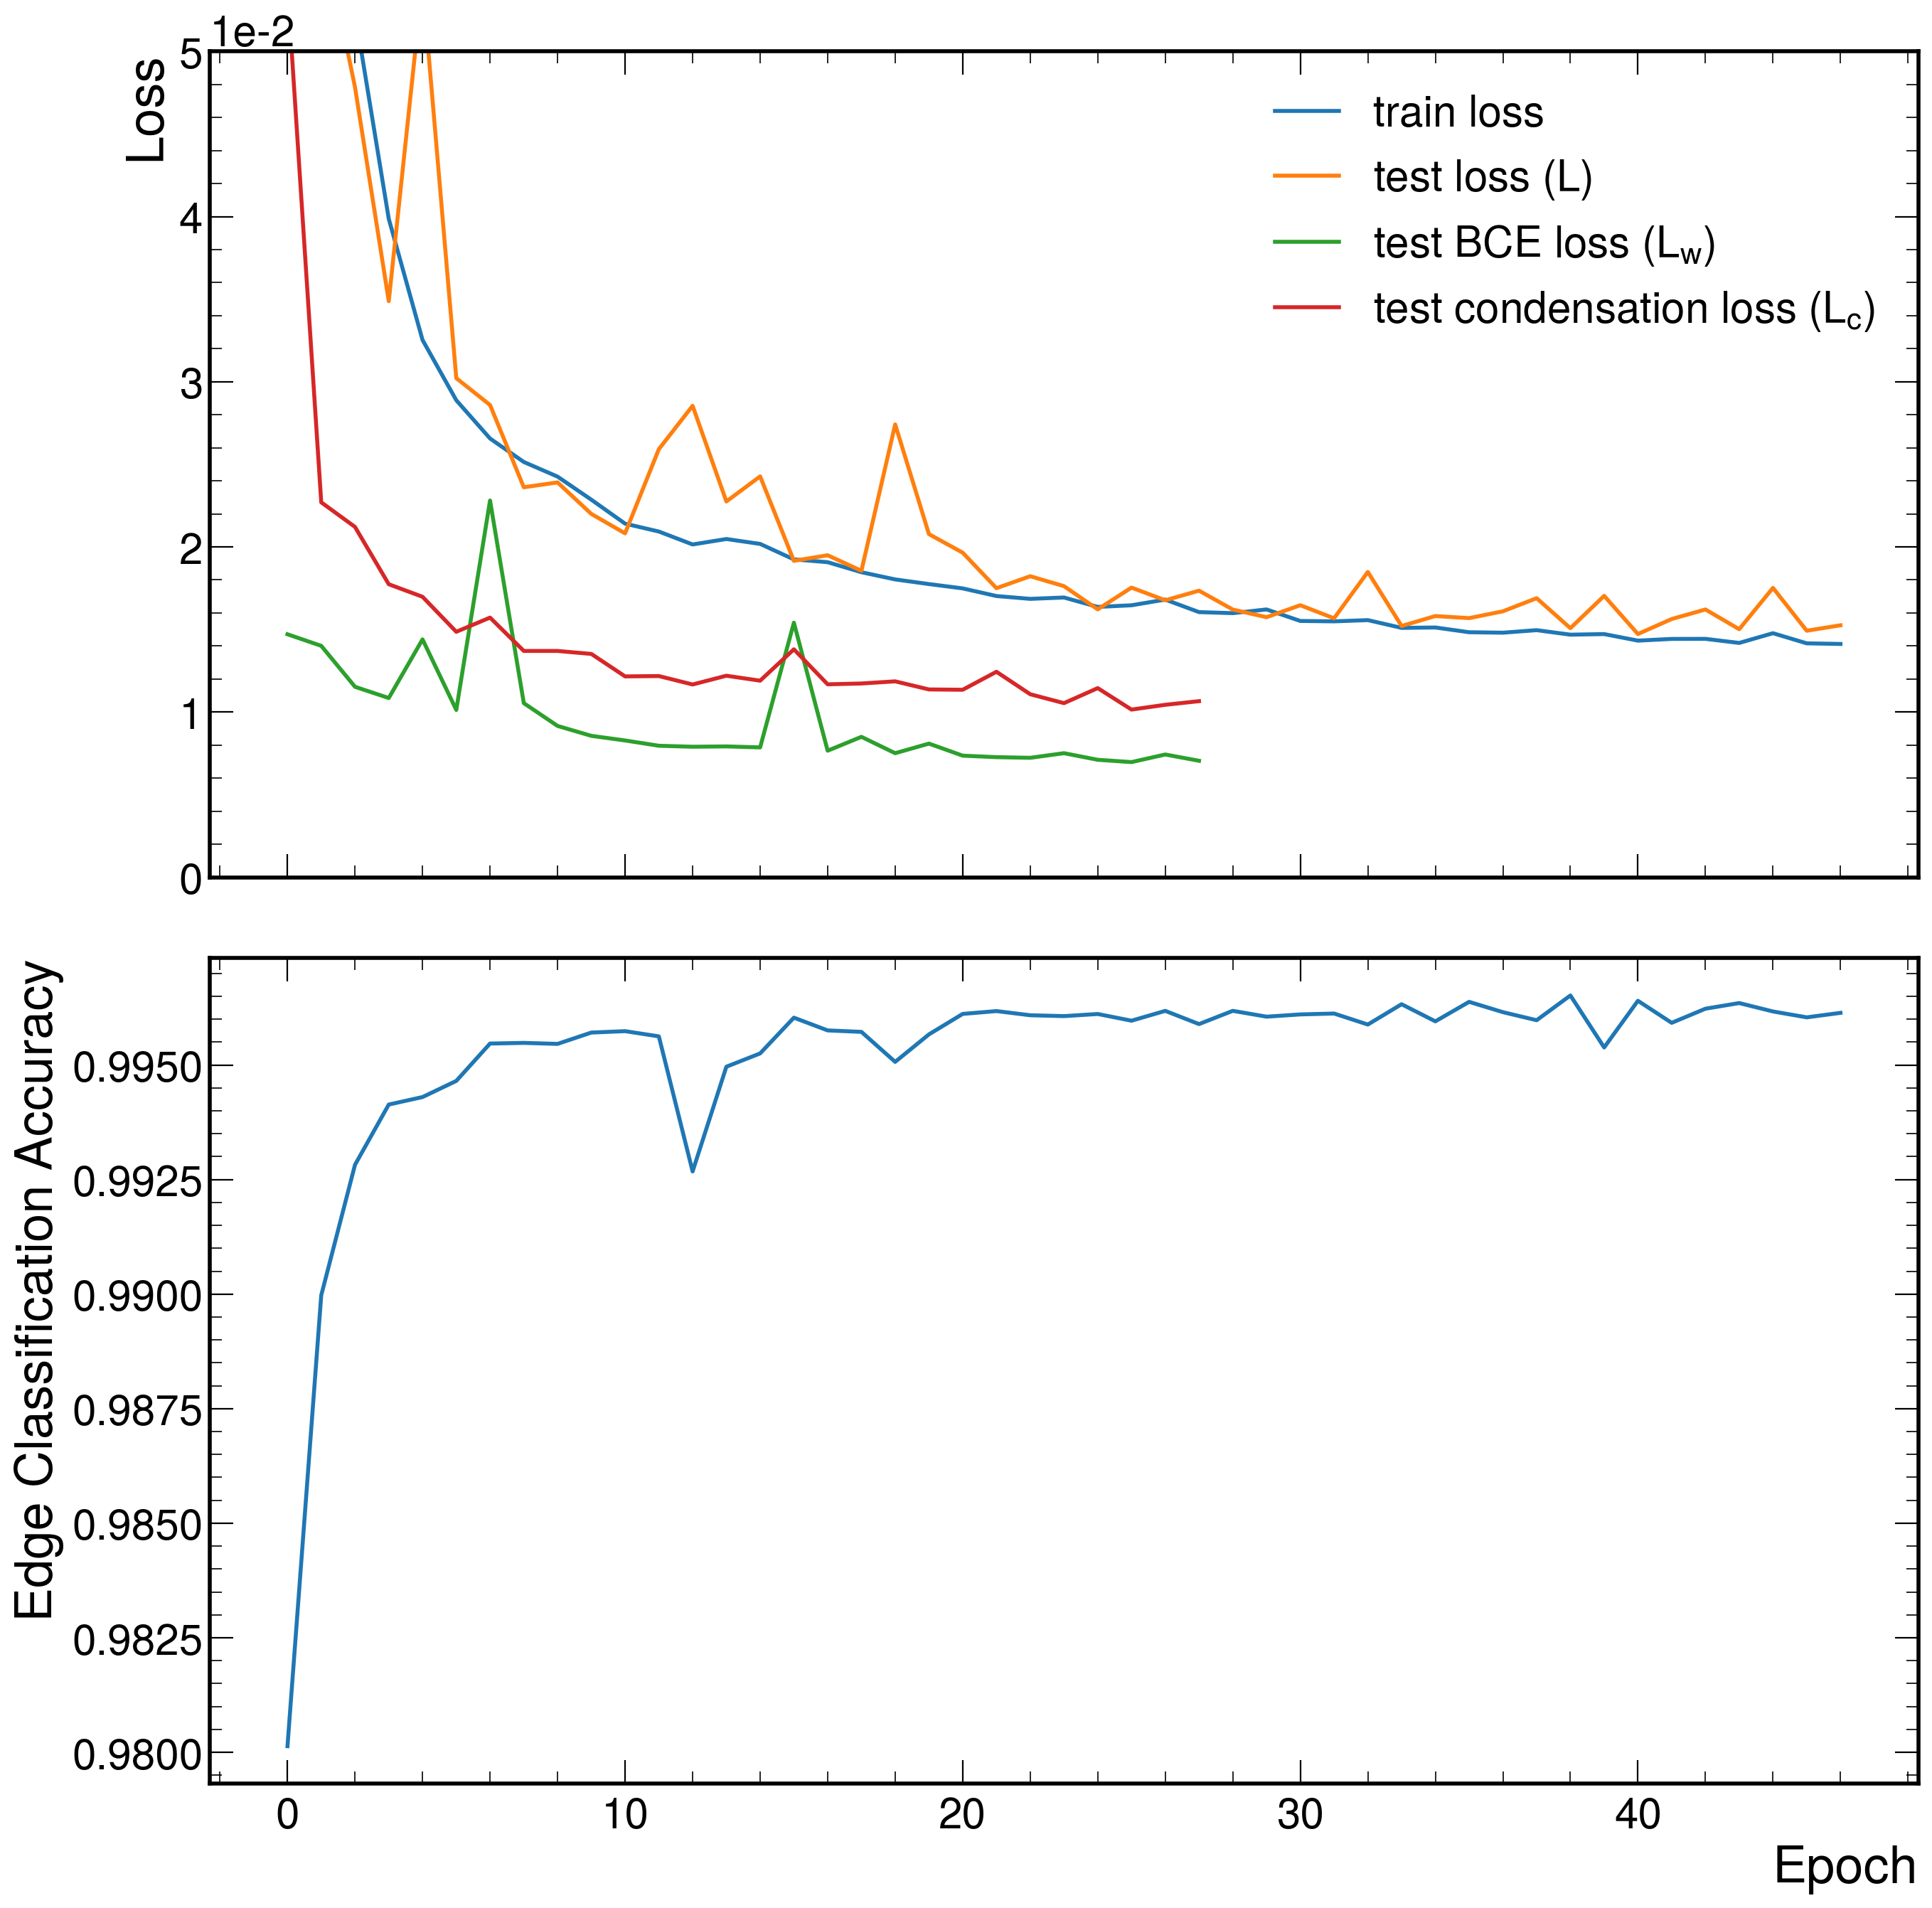

In [11]:
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.pyplot import cm
from sklearn.cluster import DBSCAN
from random import shuffle
from collections import Counter
import mplhep as hep

plt.style.use(hep.style.CMS)

colors = cm.Paired.colors
losses_w = [
    0.01471,
    0.01401,
    0.01153,
    0.01085,
    0.01440,
    0.01013,
    0.02281,
    0.01054,
    0.00916,
    0.00856,
    0.00828,
    0.00796,
    0.00790,
    0.00792,
    0.00786,
    0.01541,
    0.00766,
    0.00850,
    0.00751,
    0.00809,
    0.00736,
    0.00727,
    0.00723,
    0.00751,
    0.00711,
    0.00697,
    0.00743,
    0.00705,
]
losses_c = [
    0.05393,
    0.0227,
    0.02121,
    0.01774,
    0.01698,
    0.01486,
    0.01572,
    0.01370,
    0.01370,
    0.01352,
    0.01216,
    0.01218,
    0.01167,
    0.01220,
    0.01190,
    0.01380,
    0.01168,
    0.01173,
    0.01186,
    0.01137,
    0.01135,
    0.01244,
    0.01108,
    0.01054,
    0.01145,
    0.01015,
    0.01044,
    0.01066,
]
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(14, 14), dpi=200, sharex=True)
train_out = np.load(
    "../trained_models/ORF543/train_stats/ptmin_1GeV_new.npy", allow_pickle=True
).item()
n_epoch = len(train_out["test_loss"])
epochs = np.arange(1, n_epoch + 1, 1)
axs[0].plot(
    train_out["train_loss"],
    markersize=15,
    linewidth=2,
    linestyle="-",
    label="train loss",
)
axs[0].plot(
    train_out["test_loss"],
    markersize=15,
    linewidth=2,
    linestyle="-",
    label="test loss ($\mathcal{L}$)",
)
axs[0].plot(
    losses_w,
    markersize=15,
    linewidth=2,
    linestyle="-",
    label="test BCE loss ($\mathcal{L}_w$)",
)
axs[0].plot(
    losses_c,
    markersize=15,
    linewidth=2,
    linestyle="-",
    label="test condensation loss ($\mathcal{L}_c$)",
)
axs[1].plot(
    train_out["test_acc"],
    markersize=15,
    linewidth=2,
    linestyle="-",
    label="test accuracy",
)

# axs[0].legend(loc='best')
# axs[0].set_ylim([0.001,0.007])

axs[0].set_ylabel("Loss")
# axs[0].set_xlabel('Epoch')
axs[0].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
axs[0].set_ylim([0, 0.05])

# axs[1].set_ylim([0.9965,0.999])
axs[1].set_ylabel("Edge Classification Accuracy")
axs[1].set_xlabel("Epoch")
# axs[1].set_yticks([0.9965,0.997,0.9975,0.998,0.9985,0.999])

# plt.savefig('paper_plots/training_convergence.pdf', format='PDF', bbox_inches='tight')
axs[0].legend(loc="best")
plt.tight_layout()
plt.show()

In [14]:
# look at the results on a single event (1200)
device = "cpu"
model_dir = "../trained_models/ORF543"
model = "ptmin_1GeV_epoch46_new.pt"
gnn = GNN().to(device)
gnn.load_state_dict(
    torch.load(os.path.join(model_dir, model), map_location=torch.device(device))
)

input_dir = "../graphs/train1_ptmin1"
evt_of_interest = "1200"
graph_files = np.array(os.listdir(input_dir))
graph_paths = np.array(
    [
        os.path.join(input_dir, graph_file)
        for graph_file in graph_files
        if evt_of_interest in graph_file
    ]
)
print(f"examining {len(graph_paths)} files:\n", graph_paths)

params = {"batch_size": 1, "shuffle": True, "num_workers": 1}
test_set = GraphDataset(graph_files=graph_paths)
test_loader = DataLoader(test_set, **params)

examining 64 files:
 ['../graphs/train1_ptmin1/event000001200_s22.npz'
 '../graphs/train1_ptmin1/event000001200_s59.npz'
 '../graphs/train1_ptmin1/event000001200_s62.npz'
 '../graphs/train1_ptmin1/event000001200_s18.npz'
 '../graphs/train1_ptmin1/event000001200_s63.npz'
 '../graphs/train1_ptmin1/event000001200_s13.npz'
 '../graphs/train1_ptmin1/event000001200_s10.npz'
 '../graphs/train1_ptmin1/event000001200_s48.npz'
 '../graphs/train1_ptmin1/event000001200_s27.npz'
 '../graphs/train1_ptmin1/event000001200_s6.npz'
 '../graphs/train1_ptmin1/event000001200_s43.npz'
 '../graphs/train1_ptmin1/event000001200_s55.npz'
 '../graphs/train1_ptmin1/event000001200_s23.npz'
 '../graphs/train1_ptmin1/event000001200_s17.npz'
 '../graphs/train1_ptmin1/event000001200_s1.npz'
 '../graphs/train1_ptmin1/event000001200_s46.npz'
 '../graphs/train1_ptmin1/event000001200_s16.npz'
 '../graphs/train1_ptmin1/event000001200_s33.npz'
 '../graphs/train1_ptmin1/event000001200_s26.npz'
 '../graphs/train1_ptmin1/event

In [ ]:
gnn.eval()
thld = 0.153  # from validation sample
output = {"test_loss": [], "test_acc": []}
# eps_per_sector = {'2': 0.3564241822816778, '22': 0.45843991876458323, '30': 0.4169384299062302, '29': 0.38705057106242907, '26': 0.3455041866230518, '10': 0.36766370445586516, '1': 0.3036541924266648, '48': 0.18149576536563505, '25': 0.19704120326178534, '41': 0.26664902466066226, '56': 0.2157166192270978, '53': 0.4097118708407425, '14': 0.5776026396967548, '52': 0.4897099302911026, '17': 0.32234367029956457, '37': 0.45964267052796437, '47': 0.20748764032469144, '40': 0.11834033780629383, '50': 0.3648087553192596, '43': 0.6117603874427162, '57': 0.2814069607914131, '39': 0.19480088644724136, '4': 0.4797073653156661, '20': 0.4320027929704173, '36': 0.6628498681482498, '62': 0.30954201040247753, '28': 0.5171349701504945, '42': 0.418948477000258, '15': 0.2508787160267514, '16': 0.21156652945703436, '21': 0.41145608668912287, '35': 0.5350950945118965, '12': 0.4732929783854891, '33': 0.2509914058302759, '34': 0.3345035199042572, '54': 0.3544828443971243, '6': 0.3605703464644229, '45': 0.4970332493010159, '23': 0.15307456520675453, '9': 0.2928337271520215, '63': 0.21375156675561108, '27': 0.4600810743406718, '13': 0.33493758583269617, '49': 0.23781110190043425, '0': 0.1672453080584718, '44': 0.6048629114697928, '58': 0.37508685961178423, '61': 0.376480475496482, '55': 0.24918232797162998, '60': 0.45978119605346224, '31': 0.4860280909701997, '18': 0.3524482894718338, '19': 0.36911811362641156, '38': 0.384640685382996, '24': 0.17406356539277051, '5': 0.3427366006854611, '32': 0.18318814309046946, '3': 0.4765896040481174, '8': 0.13300241176133498, '7': 0.27902516215008294, '51': 0.4240012533714197, '11': 0.4463760096499357, '46': 0.3890997229178218, '59': 0.7288422692248555}
# eps_per_sector = {'2': 0.8063548272690922, '22': 0.299405179960324, '30': 0.28859853655239975, '29': 0.33339633574780086, '26': 0.5236165326325144, '10': 0.5216460111562207, '1': 0.2878294081123941, '48': 0.22263953508649145, '25': 0.34931555338021225, '41': 0.33230337108552677, '56': 0.20547030457458215, '53': 0.3559793988629558, '14': 0.24844131669585412, '52': 0.5608325417346683, '17': 0.3456908316257858, '37': 0.3922355410981205, '47': 0.2039827087386243, '40': 0.19807322950134404, '50': 1.1135923658563385, '43': 0.5331037394268494, '57': 0.2710876333023264, '39': 0.19920797777676114, '4': 0.44904851441225124, '20': 0.602187737520835, '36': 0.5466592138502525, '62': 0.24127534088551628, '28': 0.5347594761474337, '42': 0.41772241226028095, '15': 0.24230064272641902, '16': 0.1943095736137368, '21': 1.0508085294451583, '35': 0.378743656658796, '12': 0.5591883019759802, '33': 0.33630823925312137, '34': 0.43069772694509106, '54': 0.2785143389761452, '6': 0.306822059393292, '45': 0.46596615711030376, '23': 0.19588896863672595, '9': 0.3572548379207321, '63': 0.17333863999794852, '27': 0.6171556193101095, '13': 0.41517929321316493, '49': 0.42404231447481017, '0': 0.2740409028474836, '44': 0.4495038154213366, '58': 0.676606553714549, '61': 0.6486801322347483, '55': 0.2262980339273397, '60': 0.5528389471875124, '31': 0.22853232441126992, '18': 0.44848417813676533, '19': 0.4531880461432393, '38': 0.2857591954424449, '24': 0.2684531593154434, '5': 0.4045195515657686, '32': 0.21747424924573708, '3': 0.5348996145154985, '8': 0.2211579281046795, '7': 0.24975328523382798, '51': 0.5185944888548765, '11': 0.5056706399944967, '46': 0.25581046164540183, '59': 1.1737162383743445}
eps_per_sector = {
    "2": 0.5495896408725386,
    "22": 0.2066768835039086,
    "30": 0.32207736849433066,
    "29": 0.2153735994036366,
    "26": 0.33333082879262993,
    "10": 0.4483006357560373,
    "1": 0.15084099122235584,
    "48": 0.09133902135173017,
    "25": 0.1851028928201932,
    "41": 0.21531603307034636,
    "56": 0.09517457366962045,
    "53": 0.26678582887569857,
    "14": 0.22142935883358877,
    "52": 0.3418372561998032,
    "17": 0.2212906430447033,
    "37": 0.19312759435470764,
    "47": 0.07242282075561883,
    "40": 0.043647137743399386,
    "50": 0.7699143485549735,
    "43": 0.3503989728702347,
    "57": 0.16920986038063074,
    "39": 0.0439630494567799,
    "4": 0.2022154563216964,
    "20": 0.3449003159515353,
    "36": 0.2526325497354306,
    "62": 0.13945573208896572,
    "28": 0.33674114954372225,
    "42": 0.2552393778183979,
    "15": 0.10452628934529434,
    "16": 0.10424390260245978,
    "21": 0.7380104344215415,
    "35": 0.1978508778392623,
    "12": 0.2676435293824886,
    "33": 0.2696216773866944,
    "34": 0.22186430182786004,
    "54": 0.1762268184405068,
    "6": 0.24255059505853188,
    "45": 0.2674585713555141,
    "23": 0.10362311667582357,
    "9": 0.235383881318328,
    "63": 0.08119582817237184,
    "27": 0.3838984846446019,
    "13": 0.3159058507535464,
    "49": 0.18657413342638907,
    "0": 0.11556407496284879,
    "44": 0.2883726398338603,
    "58": 0.42306760019056955,
    "61": 0.42685130034012675,
    "55": 0.11039074677407099,
    "60": 0.3684585347152781,
    "31": 0.11313115839546933,
    "18": 0.22274020570291234,
    "19": 0.2577446903341364,
    "38": 0.23418950808364947,
    "24": 0.10320896502403629,
    "5": 0.23951099655502492,
    "32": 0.10256076156375457,
    "3": 0.3988297609696611,
    "8": 0.13298719725169572,
    "7": 0.10731956348135153,
    "51": 0.34252400841044667,
    "11": 0.3431829658915274,
    "46": 0.19143257049887802,
    "59": 0.7589238164237745,
}
summary_stats = {
    "n_pids": 0,
    "perfect_matches": 0,
    "double_majority": 0,
    "lhc_loose_matches": 0,
}
with torch.no_grad():
    for batch_idx, (data, f) in enumerate(test_loader):
        print(f)
        sector = f[0].split("_s")[-1].split(".npz")[0]
        print("analyzing sector", sector)
        data = data.to(device)
        out, xc, beta = gnn(data.x, data.edge_index, data.edge_attr)
        y, out = data.y, out.squeeze(1)
        particle_id = data.particle_id

        #######################################
        # output event file for DBScan studies
        d = {"x1": xc[:, 0], "x2": xc[:, 1], "particle_id": particle_id}
        df = pd.DataFrame(data=d)
        # df.to_csv(f'../cluster_predictions/event{evt_of_interest}_s{sector}_ptmin1GeV.csv', index=False)
        #######################################

        loss = F.binary_cross_entropy(out, y, reduction="mean")
        loss_c = (
            condensation_loss(beta, xc, particle_id, device=device, q_min=0.05) * 10
        )  # (10**2)
        print("condensation loss", loss_c.item())
        loss += loss_c

        TP = torch.sum((y == 1) & (out > thld)).item()
        TN = torch.sum((y == 0) & (out < thld)).item()
        FP = torch.sum((y == 0) & (out > thld)).item()
        FN = torch.sum((y == 1) & (out < thld)).item()
        acc = (TP + TN) / (TP + TN + FP + FN)

        print("edge weight loss", loss)
        print("condensation loss", loss_c)
        output["test_acc"].append(acc)
        output["test_loss"].append(loss)

        n_pids = len(torch.unique(particle_id))
        nhits_per_pid = {}
        single_hit_particles = 0
        for pid in torch.unique(particle_id):
            nhits = torch.sum(particle_id == pid).item()
            if nhits == 1:
                single_hit_particles += 1
            nhits_per_pid[pid.item()] = nhits
        print("number of particles", n_pids)
        print("number of tracks:", n_pids - single_hit_particles)

        db = DBSCAN(eps=eps_per_sector[sector], min_samples=2).fit(xc)
        labels = db.labels_
        n_clusters = len(np.unique(labels))
        print("number of labels:", n_clusters)
        cmap = list(cm.tab20c(np.linspace(0, 1, n_clusters)))

        perfect_matches = 0
        double_majority = 0
        lhc_loose_matches = 0
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), dpi=200)
        for label in np.unique(labels):
            xc_cluster = xc[labels == label]
            x_cluster = data.x[labels == label].numpy()
            axs[0].scatter(
                xc_cluster[:, 0], xc_cluster[:, 1], color=cmap[label], marker="."
            )

            idxs = np.argsort(x_cluster[:, 0])
            r = x_cluster[:, 0][idxs]
            z = x_cluster[:, 2][idxs]
            axs[1].scatter(z, r, color=cmap[label], marker=".")
            for i in range(len(r) - 1):
                axs[1].plot((z[i], z[i + 1]), (r[i], r[i + 1]), color=cmap[label])

            # analyze reconstruction
            pid_cluster = particle_id[labels == label].tolist()
            N = len(pid_cluster)
            pid_counts = Counter(pid_cluster)

            # handle the noise case
            if label == -1:
                continue

            # otherwise, clusters should be tracks
            most_common = pid_counts.most_common(1)[0]  # e.g. (810, 8)
            ntruth = nhits_per_pid[most_common[0]]
            if (N == most_common[1]) and (ntruth == most_common[1]):
                perfect_matches += 1
            if (most_common[1] / N > 0.5) and (most_common[1] / ntruth > 0.5):
                double_majority += 1
            if most_common[1] / ntruth > 0.75:
                lhc_loose_matches += 1

            # systematic way to tune DBSCAN eps parameter
            # *** note that this must be run on a separate graph!
            # dists_per_sector = []
            # dists_std_per_sector = []
            # for pid in particle_id:
            #    xc_cluster = xc[particle_id==pid]
            #    dists = []
            #    xc0 = xc_cluster[:,0].numpy()
            #    xc1 = xc_cluster[:,1].numpy()
            #    for i in range(len(xc0)):
            #        for j in range(len(xc0)):
            #            if j>=i: continue
            #            dists.append(np.sqrt((xc0[i]-xc0[j])**2 +
            #                                 (xc1[i]-xc1[j])**2))

            #    dists_per_sector.append(np.nanmean(dists))
            #    dists_std_per_sector.append(np.nanstd(dists))

        # print('dists_per_sector', np.nanmean(dists_per_sector))
        # print('dists_std_per_sector', np.nanstd(dists_std_per_sector))
        # eps_per_sector[sector] = np.nanmean(dists_per_sector) + np.nanmean(dists_std_per_sector)

        denominator = n_pids - single_hit_particles
        print("perfect match fraction:", perfect_matches / denominator)
        print("double majority fraction:", double_majority / denominator)
        print("lhc loose fraction:", lhc_loose_matches / denominator)
        summary_stats["n_pids"] += n_pids - single_hit_particles
        summary_stats["perfect_matches"] += perfect_matches
        summary_stats["double_majority"] += double_majority
        summary_stats["lhc_loose_matches"] += lhc_loose_matches
        axs[0].set_xlabel("$x_1$")
        axs[0].set_ylabel("$x_2$")
        axs[1].set_xlabel("$z$")
        axs[1].set_ylabel("$r$")
        plt.tight_layout()
        plt.show()
        # plt.savefig(f'../cluster_predictions/event{evt_of_interest}_s{sector}_ptmin1GeV.png', dpi=200)
    # print(eps_per_sector)

# entire event summary
print("summary of full event")
n_pids = summary_stats["n_pids"]
print("perfect match fraction:", summary_stats["perfect_matches"] / n_pids)
print("double majority fraction:", summary_stats["double_majority"] / n_pids)
print("lhc loose fraction:", summary_stats["lhc_loose_matches"] / n_pids)

In [ ]:
# now calculate the efficiencies per sector across an unseen sample of graphs
gnn.eval()
thld = 0.153
output = {"test_loss": [], "test_acc": []}
eps_per_sector = {
    "2": 0.8063548272690922,
    "22": 0.299405179960324,
    "30": 0.28859853655239975,
    "29": 0.33339633574780086,
    "26": 0.5236165326325144,
    "10": 0.5216460111562207,
    "1": 0.2878294081123941,
    "48": 0.22263953508649145,
    "25": 0.34931555338021225,
    "41": 0.33230337108552677,
    "56": 0.20547030457458215,
    "53": 0.3559793988629558,
    "14": 0.24844131669585412,
    "52": 0.5608325417346683,
    "17": 0.3456908316257858,
    "37": 0.3922355410981205,
    "47": 0.2039827087386243,
    "40": 0.19807322950134404,
    "50": 1.1135923658563385,
    "43": 0.5331037394268494,
    "57": 0.2710876333023264,
    "39": 0.19920797777676114,
    "4": 0.44904851441225124,
    "20": 0.602187737520835,
    "36": 0.5466592138502525,
    "62": 0.24127534088551628,
    "28": 0.5347594761474337,
    "42": 0.41772241226028095,
    "15": 0.24230064272641902,
    "16": 0.1943095736137368,
    "21": 1.0508085294451583,
    "35": 0.378743656658796,
    "12": 0.5591883019759802,
    "33": 0.33630823925312137,
    "34": 0.43069772694509106,
    "54": 0.2785143389761452,
    "6": 0.306822059393292,
    "45": 0.46596615711030376,
    "23": 0.19588896863672595,
    "9": 0.3572548379207321,
    "63": 0.17333863999794852,
    "27": 0.6171556193101095,
    "13": 0.41517929321316493,
    "49": 0.42404231447481017,
    "0": 0.2740409028474836,
    "44": 0.4495038154213366,
    "58": 0.676606553714549,
    "61": 0.6486801322347483,
    "55": 0.2262980339273397,
    "60": 0.5528389471875124,
    "31": 0.22853232441126992,
    "18": 0.44848417813676533,
    "19": 0.4531880461432393,
    "38": 0.2857591954424449,
    "24": 0.2684531593154434,
    "5": 0.4045195515657686,
    "32": 0.21747424924573708,
    "3": 0.5348996145154985,
    "8": 0.2211579281046795,
    "7": 0.24975328523382798,
    "51": 0.5185944888548765,
    "11": 0.5056706399944967,
    "46": 0.25581046164540183,
    "59": 1.1737162383743445,
}
# eps_per_sector = {'2': 0.5495896408725386, '22': 0.2066768835039086, '30': 0.32207736849433066, '29': 0.2153735994036366, '26': 0.33333082879262993, '10': 0.4483006357560373, '1': 0.15084099122235584, '48': 0.09133902135173017, '25': 0.1851028928201932, '41': 0.21531603307034636, '56': 0.09517457366962045, '53': 0.26678582887569857, '14': 0.22142935883358877, '52': 0.3418372561998032, '17': 0.2212906430447033, '37': 0.19312759435470764, '47': 0.07242282075561883, '40': 0.043647137743399386, '50': 0.7699143485549735, '43': 0.3503989728702347, '57': 0.16920986038063074, '39': 0.0439630494567799, '4': 0.2022154563216964, '20': 0.3449003159515353, '36': 0.2526325497354306, '62': 0.13945573208896572, '28': 0.33674114954372225, '42': 0.2552393778183979, '15': 0.10452628934529434, '16': 0.10424390260245978, '21': 0.7380104344215415, '35': 0.1978508778392623, '12': 0.2676435293824886, '33': 0.2696216773866944, '34': 0.22186430182786004, '54': 0.1762268184405068, '6': 0.24255059505853188, '45': 0.2674585713555141, '23': 0.10362311667582357, '9': 0.235383881318328, '63': 0.08119582817237184, '27': 0.3838984846446019, '13': 0.3159058507535464, '49': 0.18657413342638907, '0': 0.11556407496284879, '44': 0.2883726398338603, '58': 0.42306760019056955, '61': 0.42685130034012675, '55': 0.11039074677407099, '60': 0.3684585347152781, '31': 0.11313115839546933, '18': 0.22274020570291234, '19': 0.2577446903341364, '38': 0.23418950808364947, '24': 0.10320896502403629, '5': 0.23951099655502492, '32': 0.10256076156375457, '3': 0.3988297609696611, '8': 0.13298719725169572, '7': 0.10731956348135153, '51': 0.34252400841044667, '11': 0.3431829658915274, '46': 0.19143257049887802, '59': 0.7589238164237745}

summary_stats = {
    "n_pids": 0,
    "perfect_matches": 0,
    "double_majority": 0,
    "lhc_loose_matches": 0,
}

input_dir = "../graphs/ptmin_1GeV_train2"
graph_files = np.array(os.listdir(input_dir))
graph_paths = np.array(
    [os.path.join(input_dir, graph_file) for graph_file in graph_files]
)

params = {"batch_size": 1, "shuffle": True, "num_workers": 1}
test_set = GraphDataset(graph_files=graph_paths)
test_loader = DataLoader(test_set, **params)
with torch.no_grad():
    for batch_idx, (data, f) in enumerate(test_loader):
        sector = f[0].split("_s")[-1].split(".npz")[0]
        # print('analyzing sector', sector)
        data = data.to(device)
        out, xc, beta = gnn(data.x, data.edge_index, data.edge_attr)
        y, out = data.y, out.squeeze(1)
        particle_id = data.particle_id
        loss = F.binary_cross_entropy(out, y, reduction="mean")
        loss_c = (
            condensation_loss(beta, xc, particle_id, device=device, q_min=0.05) * 10
        )  # (10**2)
        # print('condensation loss', loss_c.item())
        loss += loss_c

        TP = torch.sum((y == 1) & (out > thld)).item()
        TN = torch.sum((y == 0) & (out < thld)).item()
        FP = torch.sum((y == 0) & (out > thld)).item()
        FN = torch.sum((y == 1) & (out < thld)).item()
        acc = (TP + TN) / (TP + TN + FP + FN)

        output["test_acc"].append(acc)
        output["test_loss"].append(loss)

        n_pids = len(torch.unique(particle_id))
        nhits_per_pid = {}
        single_hit_particles = 0
        for pid in torch.unique(particle_id):
            nhits = torch.sum(particle_id == pid).item()
            if nhits == 1:
                single_hit_particles += 1
            nhits_per_pid[pid.item()] = nhits

        db = DBSCAN(eps=eps_per_sector[sector], min_samples=2).fit(xc)
        labels = db.labels_
        n_clusters = len(np.unique(labels))
        cmap = list(cm.tab20c(np.linspace(0, 1, n_clusters)))

        perfect_matches = 0
        double_majority = 0
        lhc_loose_matches = 0
        for label in np.unique(labels):
            # analyze reconstruction
            pid_cluster = particle_id[labels == label].tolist()
            N = len(pid_cluster)
            pid_counts = Counter(pid_cluster)

            # handle the noise case
            if label == -1:
                continue

            # otherwise, clusters should be tracks
            most_common = pid_counts.most_common(1)[0]  # e.g. (810, 8)
            ntruth = nhits_per_pid[most_common[0]]
            if (N == most_common[1]) and (ntruth == most_common[1]):
                perfect_matches += 1
            if (most_common[1] / N > 0.5) and (most_common[1] / ntruth > 0.5):
                double_majority += 1
            if most_common[1] / ntruth > 0.75:
                lhc_loose_matches += 1

        summary_stats["n_pids"] += n_pids - single_hit_particles
        summary_stats["perfect_matches"] += perfect_matches
        summary_stats["double_majority"] += double_majority
        summary_stats["lhc_loose_matches"] += lhc_loose_matches

# entire event summary
print("summary of full data sample")
n_pids = summary_stats["n_pids"]
print("perfect match fraction:", summary_stats["perfect_matches"] / n_pids)
print("double majority fraction:", summary_stats["double_majority"] / n_pids)
print("lhc loose fraction:", summary_stats["lhc_loose_matches"] / n_pids)